In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import osmnx as ox

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [6]:
block = gpd.read_file('/home/edgar/SIG/Info_Grl/'+
                      'Info_Sociodemografica/Censo/2020/'+
                      'CntMnzCPyV_AMG_INEGI20_UTM_v1.shp', driver='ESRIShapefile')
print(block.shape)
block.head(2)

(60121, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,field_1,ENTIDAD,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCIN,VPH_SINTIC,geometry
0,1400900690031005,14,009,0069,0031,005,Rural,Típica,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (643034.793 2291337.416)
1,1400900060243020,14,009,0006,0243,020,Urbana,Típica,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (642012.719 2294073.386)


In [7]:
block.columns = map(str.lower, block.columns)

<AxesSubplot:>

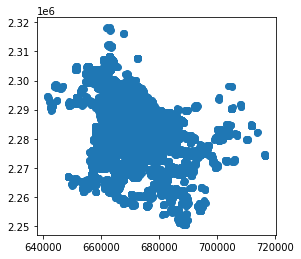

In [8]:
block.plot()

In [9]:
hex_gdf = gpd.read_file('/home/edgar/SIG/ObsCds/Proyectos/'+
                        'Museo_CienciasAmbientales/'+
                        'Medio_Urbano/Analisis/'+
                        'hexTime_PuertaSur_TransportePublico_AMG_v1.geojson', driver='GeoJSON')
hex_gdf = hex_gdf.to_crs("EPSG:32613")
print(hex_gdf.shape)
hex_gdf.head(2)

(12395, 17)


,hex_id_9,level_0,index,fid,cat,Ruta_id,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,x,y,street_count,tiempo_museo,geometry
0,8949aa26963ffff,153256.0,152027.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-103.572301,20.466121,3.0,495.993122,"POLYGON ((648876.080 2263500.426, 649001.310 2..."
1,8949aa26c6fffff,118645.5,117416.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-103.554734,20.430922,3.0,451.761935,"POLYGON ((650875.554 2259738.930, 651000.780 2..."


<AxesSubplot:>

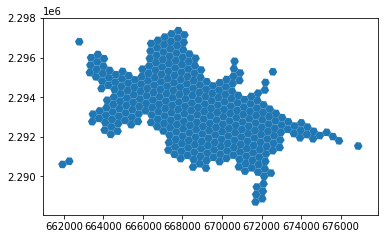

In [11]:
hex_gdf.loc[hex_gdf.tiempo_museo<=30].plot()

In [13]:
hex_gdf = hex_gdf.loc[hex_gdf.tiempo_museo<=30]
hex_gdf = hex_gdf[['hex_id_9','geometry']].copy()
print(hex_gdf.shape)
hex_gdf.head(2)

(354, 2)


,hex_id_9,geometry
2,89498c94347ffff,"POLYGON ((676981.855 2291328.132, 677107.089 2..."
4,89498c96b3bffff,"POLYGON ((669006.465 2290806.860, 669131.703 2..."


In [9]:
avg_column = [
    "prom_hnv",
    "graproes",
    "graproes_f",
    "graproes_m",
    "prom_ocup",
    "pro_ocup_c",
]
# sum data for weighted averaged
avg_dict = {
    "prom_hnv": "pobtot",
    "graproes": "pobtot",
    "graproes_f": "pobfem",
    "graproes_m": "pobmas",
    "prom_ocup": "tvivparhab",
    "pro_ocup_c": "tvivparhab",
}

string_columns = [
    'cvegeo',
    'cve_ent',
    'cve_mun',
    'cve_loc',
    'cve_ageb',
    'cve_mza',
    'ambito',
    'tipomza',
    'field_1',
    'entidad',
    'nom_ent',
    'mun',
    'nom_mun',
    'loc',
    'nom_loc',
    'ageb',
    'mza'
]

column_start = 16
column_end = len(block)-1

In [15]:
hex_pop = aup.socio_points_to_polygon(hex_gdf, block[['pobtot','geometry']],'hex_id_9',
                                     string_columns=[])

In [16]:
print(hex_pop.shape)
hex_pop.head(5)

(344, 2)


,pobtot,hex_id_9
0,1959.0,89498c94ec3ffff
0,1020.0,89498c94ecbffff
0,1338.0,89498c94ec7ffff
0,1802.0,89498c94cb3ffff
0,1410.0,89498c94c87ffff


In [17]:
hex_pop.pobtot.sum()

437164.0

In [18]:
hex_mrg = hex_gdf.merge(hex_pop, on='hex_id_9')

In [19]:
hex_mrg['dens_pobha'] = hex_mrg.pobtot / (hex_mrg.area / 10000)

<AxesSubplot:>

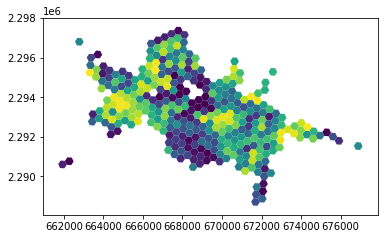

In [20]:
hex_mrg.plot('dens_pobha', 'viridis')

## Download Marginalization nodes

In [21]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [25]:
query = f"SELECT * FROM censo.nodes_marg_2020 WHERE (ST_Intersects(geometry, \'SRID=4326; {poly_wkt}\'))"
nodes_marg = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes_marg.shape)
nodes_marg.head(2)

(14205, 31)


,x,y,street_count,geometry,cve_geo_ageb,cve_ent,cve_mun,cve_loc,cve_ageb,CVE_AGEB,...,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,-103.309573,20.717037,0,POINT (-103.30957 20.71704),1403900013088,14,039,0001,3088,1403900013088,...,0.000224,0.000561,0.000337,0.006733,0.012793,0.174864,0.041975,0.135449,122.378334,0.955974
1,-103.311069,20.715848,0,POINT (-103.31107 20.71585),1403900013088,14,039,0001,3088,1403900013088,...,0.000224,0.000561,0.000337,0.006733,0.012793,0.174864,0.041975,0.135449,122.378334,0.955974


<AxesSubplot:>

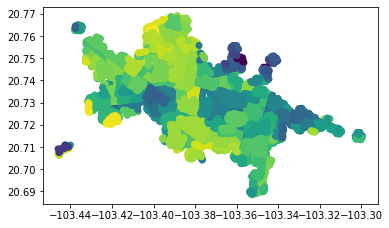

In [26]:
nodes_marg.plot('im_2020')

In [39]:
nodes_marg[['pobtot','imn_2020','im_2020','geometry']].pobtot.sum()

441951.031378547

In [28]:
avg_column = [
    "imn_2020",
    "im_2020",
]
# sum data for weighted averaged
avg_dict = {
    "imn_2020":"pobtot",
    "im_2020":"pobtot",
}

string_columns = []

In [44]:
hex_gdf = hex_gdf.to_crs("EPSG:4326")

hex_marg = aup.socio_points_to_polygon(hex_gdf, nodes_marg[['pobtot','imn_2020',
                                                             'im_2020','geometry']],
                                        'hex_id_9',
                                     string_columns=[],
                                       wgt_dict=avg_dict,
                                       avg_column=avg_column)
hex_marg.drop(columns='pobtot', inplace=True)

In [45]:
hex_socio = hex_mrg.merge(hex_marg, on='hex_id_9')
print(hex_socio.shape)
hex_socio.head(2)

(344, 6)


,hex_id_9,geometry,pobtot,dens_pobha,imn_2020,im_2020
0,89498c94347ffff,"POLYGON ((-103.30050 20.71313, -103.29928 20.7...",1252.0,100.381057,0.953759,122.094884
1,89498c96b3bffff,"POLYGON ((-103.37711 20.70916, -103.37589 20.7...",287.0,23.005853,0.980307,125.493385


<AxesSubplot:>

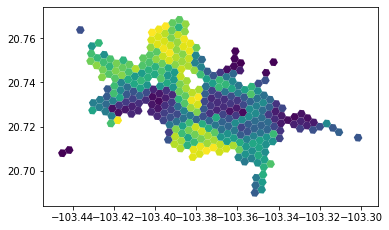

In [47]:
hex_socio.plot("im_2020", "viridis")

In [48]:
marg_limits = {'Muy alto':[115.212, 53.445],
'Alto':[118.609,115.212],
'Medio':[121.157, 118.609],
'Bajo':[123.705, 121.157],
'Muy bajo':[127.951, 123.705]}


#nse to hex bins
hex_socio['gm_2020'] = np.nan
for n in list(marg_limits.keys()):
    upper_marg = marg_limits[n][0]
    lower_marg = marg_limits[n][1]
    hex_socio.loc[(hex_socio['im_2020']>lower_marg)&
                (hex_socio['im_2020']<=upper_marg),'gm_2020'] = n

<AxesSubplot:>

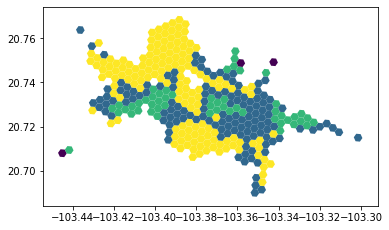

In [50]:
hex_socio.plot("gm_2020", "viridis")

In [60]:
type_dict = {'string':['hex_id_9','gm_2020'],
             'integer':['pobtot'],
             'float':['im_2020','imn_2020']  
}
hex_socio = aup.convert_type(hex_socio, type_dict)

In [61]:
hex_socio.to_file('/home/edgar/SIG/ObsCds/'+
                   'Proyectos/Museo_CienciasAmbientales/Info_Sociodemografica/'+
                   'hexSocio_30minTP_PuertaSur_v1.geojson',
                    driver='GeoJSON')